# [Project 2: Implementing a Simple Convolutional Neural Network (CNN)](https://github.com/jcp-tech/Seneca_Class_Notes/blob/master/Semester%202/AIG220%20-%20Deep%20Learning/Project%202/Project_2%20S25.ipynb)

## Introduction

In this project, you will design, implement, and evaluate a simple Convolutional Neural Network (CNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project!  (Note, however, that your work should not simply mirror models already covered in the course, nor published works of others.) Kaggle would be a good source to look for datasets. Below are some examples that we have already seen, which would be of an appropriate nature; you might tackle these (with your own approach), or choose a different dataset:
- CIFAR-10: A dataset of 60,000 32x32 color images in 10 classes with 6,000 images per class.
- Fashion-MNIST: A dataset of 70,000 28x28 grayscale images of 10 different clothing caregories.


In [20]:
# --- Imports ---
# --- Standard Libraries ---
import os
import io
import numpy as np
import pandas as pd
from PIL import Image

# --- TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,
    TensorBoard, CSVLogger, LearningRateScheduler, Callback
)
from tensorflow.keras.optimizers import Adam, SGD

# --- Sklearn ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Others ---
import kagglehub


# For GPU check
script_dir = os.getcwd()
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
def plot_classwise_samples(dataset_path, class_names, samples_per_class_per_row=6, num_rows=1):
    total_samples = samples_per_class_per_row * num_rows
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_path):
            os.makedirs(class_path, exist_ok=True)
        images = os.listdir(class_path)[:total_samples]

        # Figure width fixed to notebook width, height scales with rows
        fig, axs = plt.subplots(
            num_rows,
            samples_per_class_per_row,
            figsize=(18, 18 * num_rows / samples_per_class_per_row),
            dpi=100
        )
        fig.suptitle(f"Class: {class_name}", fontsize=16, y=1.02)

        axs = axs.flatten() if total_samples > 1 else [axs]

        for i, ax in enumerate(axs):
            if i < len(images):
                img_path = os.path.join(class_path, images[i])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.axis('off')
            else:
                ax.axis('off')

        # 🔧 Zero spacing between images
        plt.subplots_adjust(wspace=0.01, hspace=0.01)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

def find_best_epoch(history):
    val_loss = history.history['val_loss']
    best_epoch = np.argmin(val_loss) + 1  # Epochs are 1-indexed
    # val_acc = history.history['val_accuracy']
    # best_epoch = np.argmax(val_acc) + 1  # Epochs are 1-indexed
    return best_epoch

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    best_epoch = find_best_epoch(history)

    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    # plt.axhline(y=0.80, color='gray', linestyle='--', label='80% Threshold')
    plt.axvline(x=best_epoch - 1, color='red', linestyle='--', label=f'Best Epoch: {best_epoch}')
    # plt.text(best_epoch - 1, 0.82, f'Best Epoch: {best_epoch}', color='red', fontsize=10, ha='center')
    # plt.text(epochs_range[-1], 0.82, f'Final Epoch: {epochs_range[-1] + 1}', color='blue', fontsize=10, ha='right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    # plt.axhline(y=0.20, color='gray', linestyle='--', label='20% Threshold')|
    plt.axvline(x=best_epoch - 1, color='red', linestyle='--', label=f'Best Epoch: {best_epoch}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [22]:
base_path = kagglehub.dataset_download("puneet6060/intel-image-classification") # Download latest version
print("Path to dataset files:", base_path)

Path to dataset files: /home/jetauto/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [23]:
train_path = f"{base_path}/seg_train/seg_train"
test_path = f"{base_path}/seg_test/seg_test"
pred_path = f"{base_path}/seg_pred/seg_pred"
# output_dir_main = os.path.join(script_dir, "intel_predictions", "main")
# if os.path.exists(output_dir_main):
#     shutil.rmtree(output_dir_main)
# os.makedirs(output_dir_main, exist_ok=True)
class_names = sorted(os.listdir(train_path))

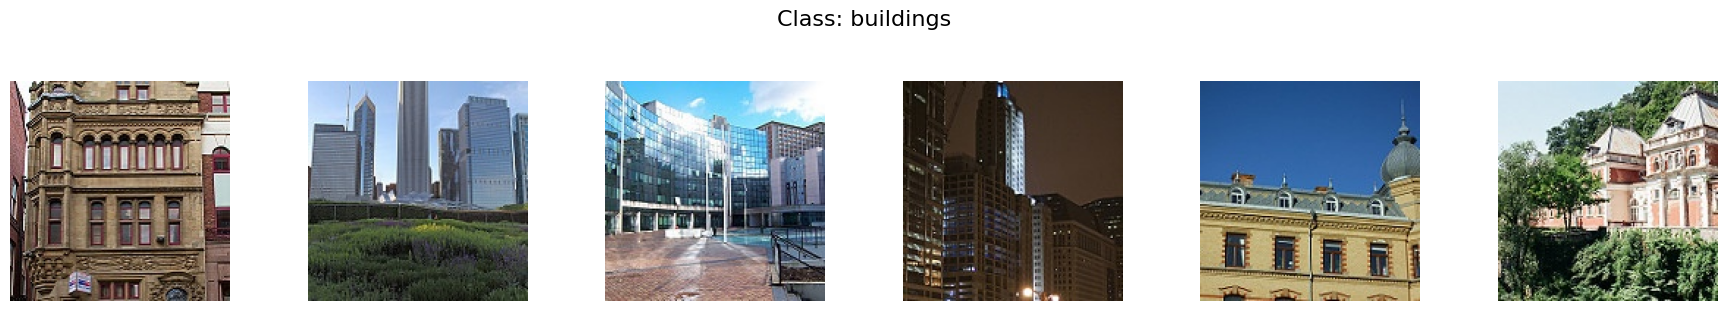

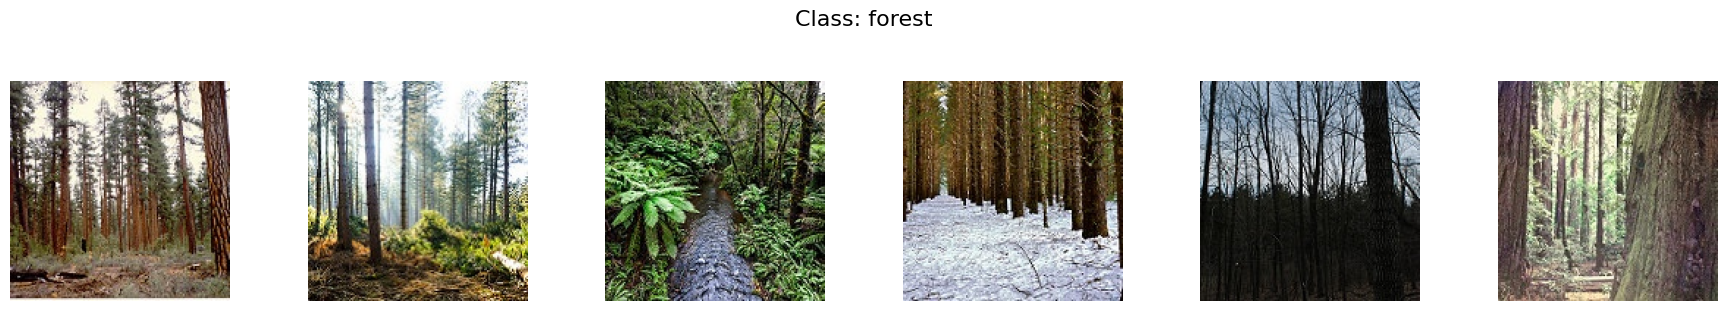

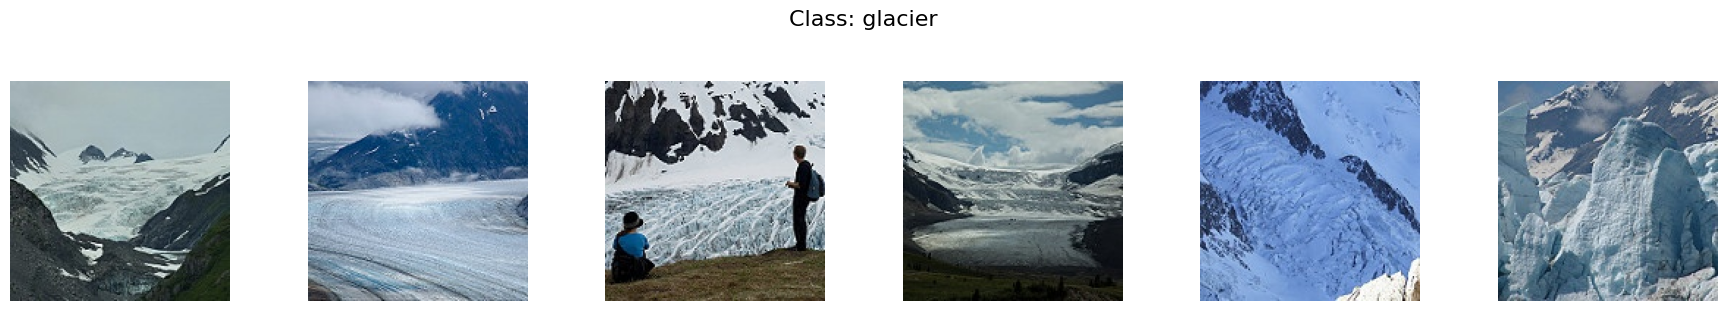

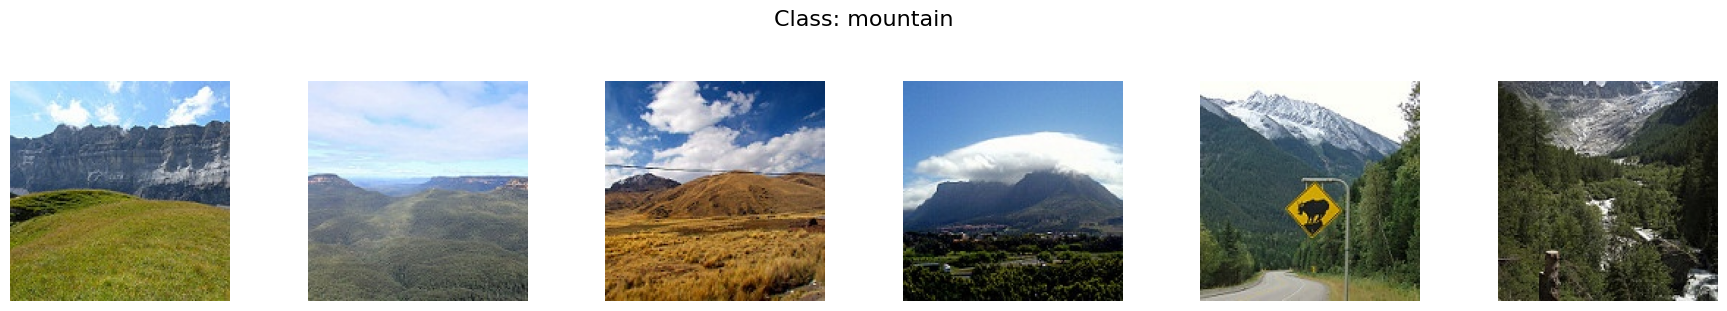

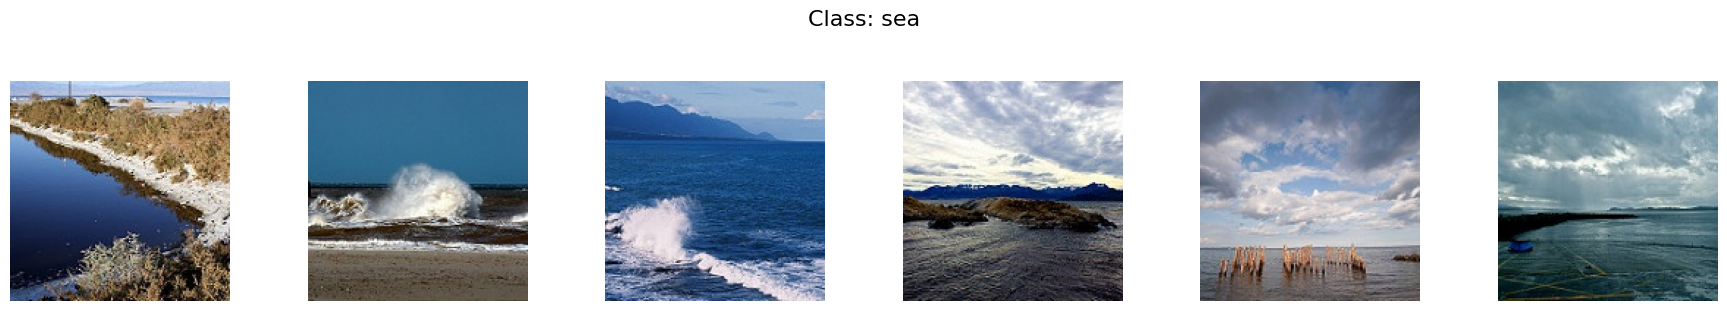

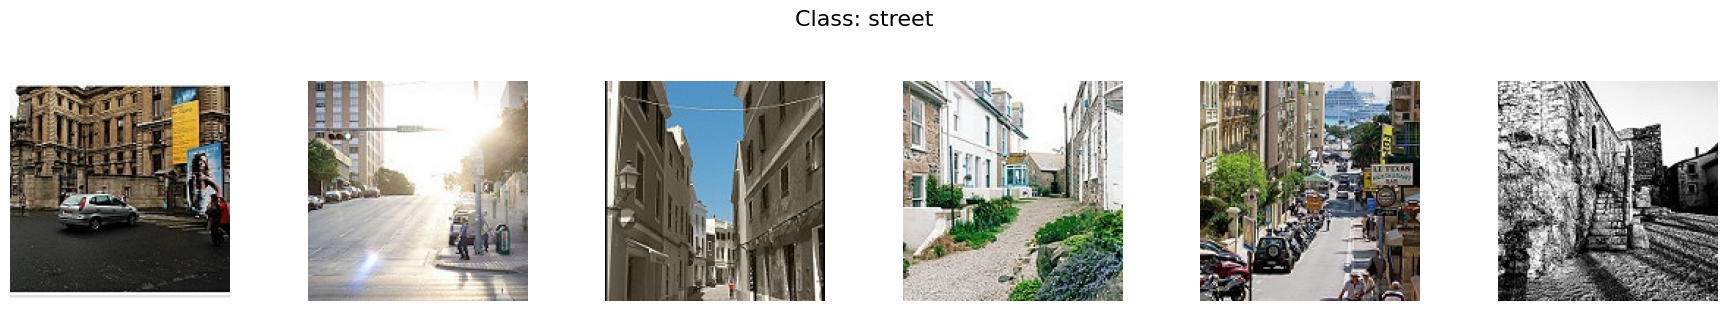

In [24]:
plot_classwise_samples(train_path, class_names) # , samples_per_class_per_row=3, num_rows=3

In [25]:
img_height = 150
img_width = 150
batch_size = 32
validation_split = 0.2
seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    validation_split=validation_split,
    seed=seed
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    validation_split=validation_split,
    seed=seed
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [26]:
labels = np.concatenate([y for x, y in train_ds], axis=0)
labels = np.argmax(labels, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.0626537951921258,
 1: 1.0198001816530426,
 2: 0.9691006387018816,
 3: 0.9366032699366033,
 4: 1.04136523836023,
 5: 0.9818118223154949}

In [27]:
# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    # mode='min',
    # verbose=1
) # ConditionalEarlyStopping(monitor='val_loss', threshold=0.80, patience=15, mode='min')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    # verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',  # Save model with best validation loss
    save_best_only=True,
    # mode='min',
    # verbose=1
)

csv_logger = CSVLogger('training_log.csv', append=True)

callbacks = [early_stopping, reduce_lr, checkpoint, csv_logger]

In [28]:
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# Define the improved model with regularization
model = models.Sequential([
    tf.keras.Input(shape=(img_height, img_width, 3)), # Define input shape here
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25), # Add Dropout after pooling
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25), # Add Dropout after pooling
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25), # Add Dropout after pooling
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5), # Add Dropout after dense layer
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005), # 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                      

In [29]:
# Train the model
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/100


2025-06-21 04:26:54.996825: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


351/351 [==============================] - 10s 23ms/step - loss: 1.5869 - accuracy: 0.4300 - val_loss: 1.4597 - val_accuracy: 0.4886 - lr: 5.0000e-04
Epoch 2/100
351/351 [==============================] - 8s 23ms/step - loss: 1.2526 - accuracy: 0.5535 - val_loss: 1.5572 - val_accuracy: 0.4872 - lr: 5.0000e-04
Epoch 3/100
351/351 [==============================] - 8s 24ms/step - loss: 1.1708 - accuracy: 0.5892 - val_loss: 1.3662 - val_accuracy: 0.5513 - lr: 5.0000e-04
Epoch 4/100
351/351 [==============================] - 8s 24ms/step - loss: 1.1307 - accuracy: 0.6103 - val_loss: 1.2815 - val_accuracy: 0.5852 - lr: 5.0000e-04
Epoch 5/100
351/351 [==============================] - 9s 25ms/step - loss: 1.0910 - accuracy: 0.6262 - val_loss: 1.2205 - val_accuracy: 0.6030 - lr: 5.0000e-04
Epoch 6/100
351/351 [==============================] - 8s 24ms/step - loss: 1.0582 - accuracy: 0.6483 - val_loss: 1.1703 - val_accuracy: 0.6183 - lr: 5.0000e-04
Epoch 7/100
351/351 [========================

In [30]:
# Load the best model
model.load_weights('best_model.keras')
loss, acc = model.evaluate(test_ds)
print(f"\n✅ Final Test Accuracy (main): {acc*100:.2f}%")

94/94 [==============================] - 1s 6ms/step - loss: 0.7595 - accuracy: 0.7687

✅ Final Test Accuracy (main): 76.87%


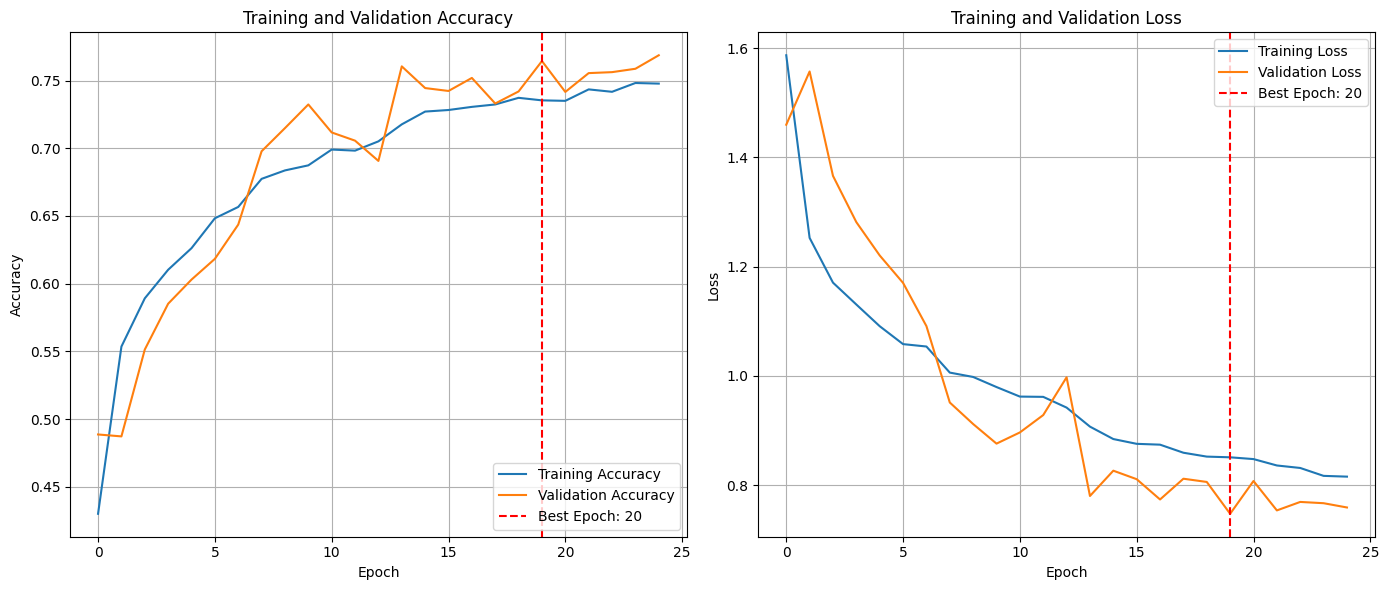

In [31]:
plot_training_history(history)

94/94 [==============================] - 0s 4ms/step


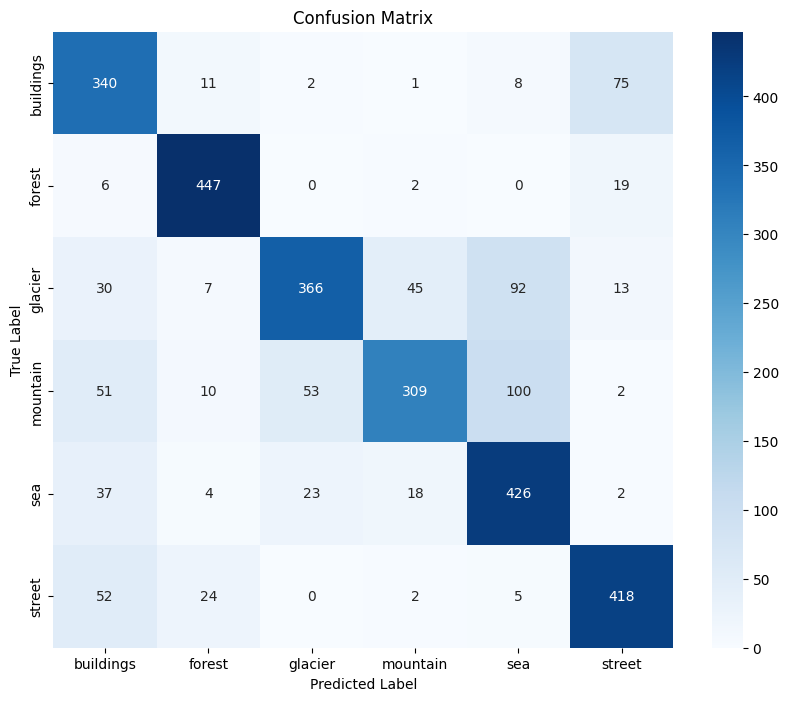

In [32]:
# Get predictions and true labels
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
test_pred_probs = model.predict(test_ds)
test_pred_labels = np.argmax(test_pred_probs, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, test_pred_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [33]:
report = classification_report(true_labels, test_pred_labels, target_names=class_names)
report_df = pd.read_csv(io.StringIO(report), sep='\s\s+', engine='python')
report_df

precision   recall  f1-score  support
buildings          0.66     0.78      0.71    437.0
forest             0.89     0.94      0.92    474.0
glacier            0.82     0.66      0.73    553.0
mountain           0.82     0.59      0.69    525.0
sea                0.68     0.84      0.75    510.0
street             0.79     0.83      0.81    501.0
accuracy           0.77  3000.00       NaN      NaN
macro avg          0.78     0.77      0.77   3000.0
weighted avg       0.78     0.77      0.77   3000.0

1/1 [==============================] - 0s 17ms/step


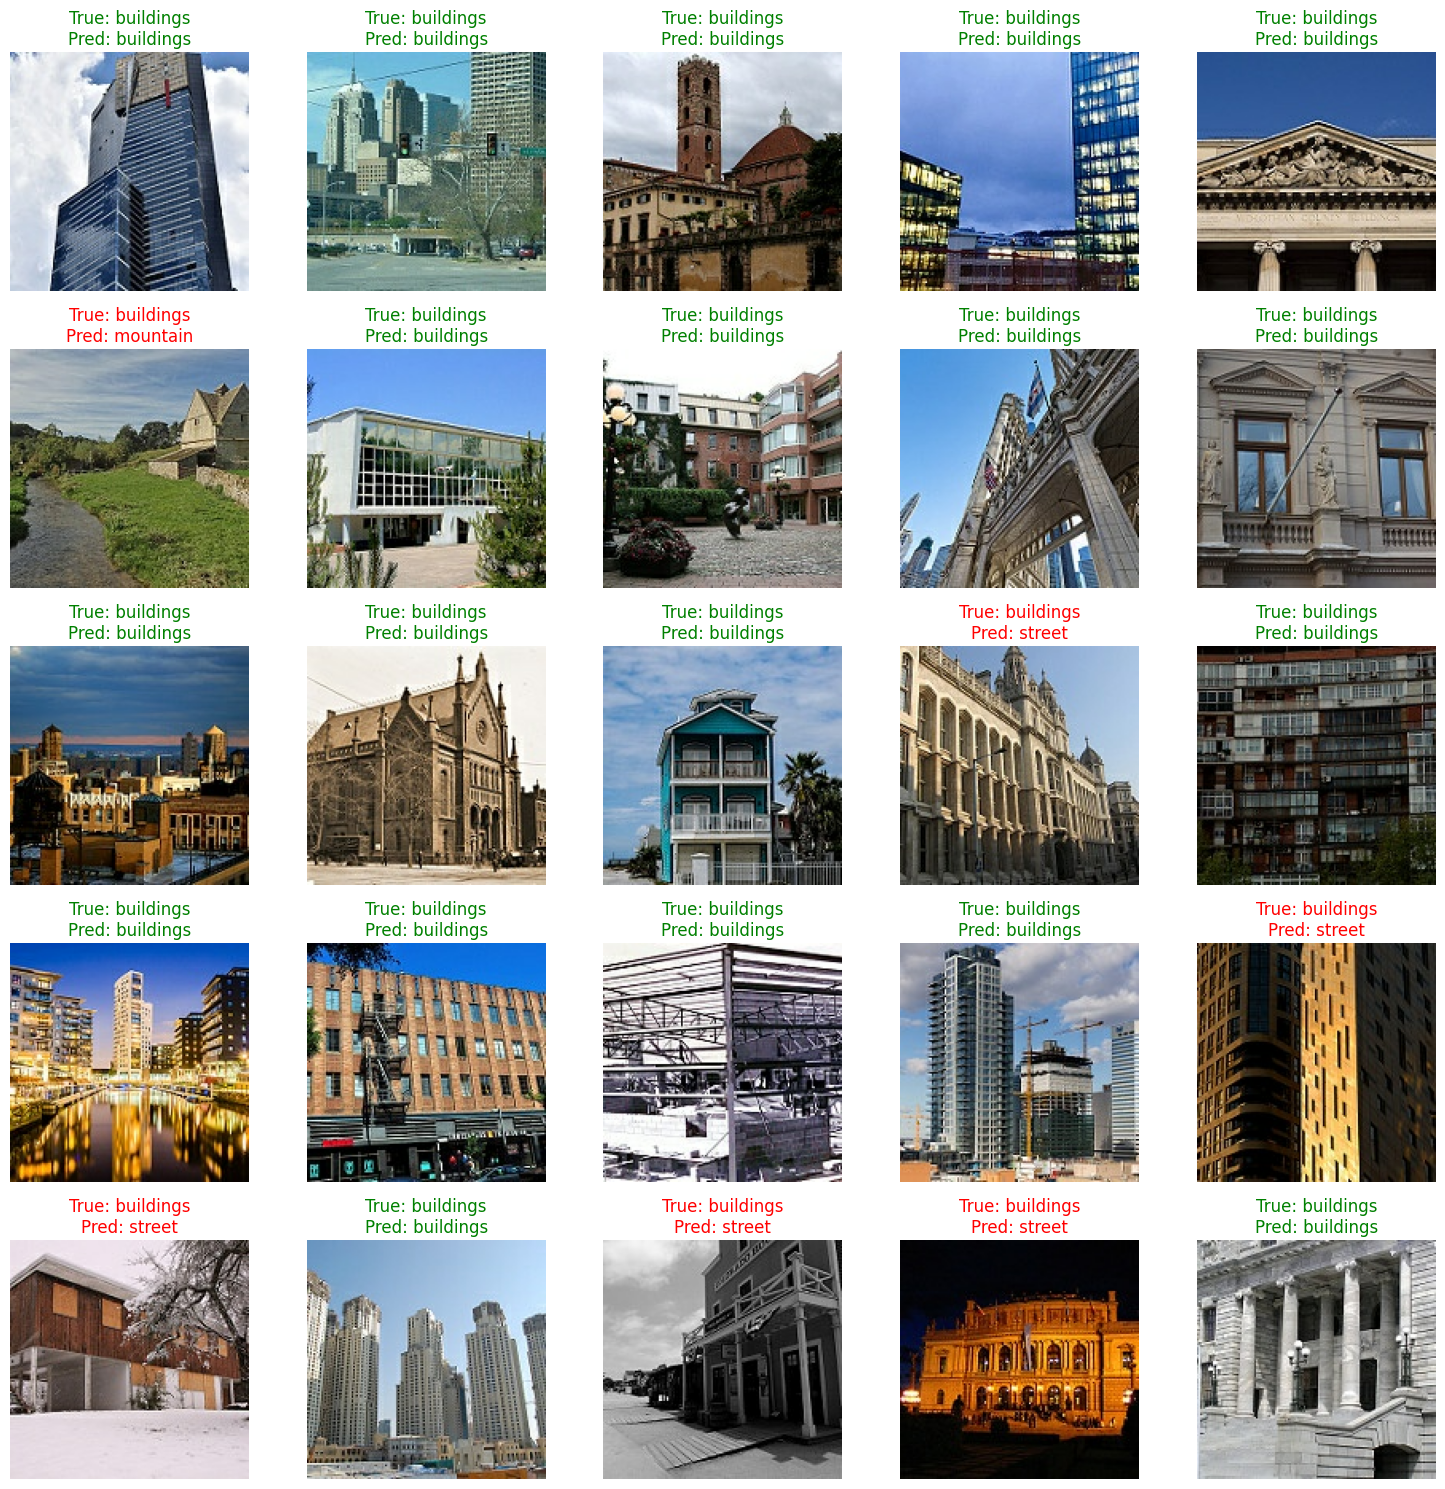

In [36]:
# Get a batch of images and labels from the test dataset
for images, labels in test_ds.take(1):
    batch_images = images
    batch_labels = labels
    break

# Get predictions for the batch
batch_predictions = model.predict(batch_images)

# Convert predictions to class labels
predicted_class_indices = np.argmax(batch_predictions, axis=1)
true_class_indices = np.argmax(batch_labels.numpy(), axis=1)

# Display images with true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(min(len(batch_images), 25)): # Display up to 25 images
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(batch_images[i].numpy().astype("uint8"))
    true_label = class_names[true_class_indices[i]]
    predicted_label = class_names[predicted_class_indices[i]]
    title_color = "green" if true_label == predicted_label else "red"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()

---
### Questions
Answer the following questions in detail.

1. What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.
2. Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?
3. What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?
4. Why are activation functions important in CNNs? Compare the use of ReLU (Rectified Linear Unit) with other activation functions.
5. Describe the process of training a CNN. What are some common challenges faced during training?
6. What are some common evaluation metrics used to assess the performance of a CNN on a classification task?
7. How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.

> Submission Folders:
- https://drive.google.com/drive/folders/174xcl6m7nZHUjlBA6i2CD7f7w_L7EUNk?usp=sharing
- https://github.com/jcp-tech/Deep-Learning-Project2-JonathanChacko